In [26]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


In [27]:
# Import the data 
ltc_com = pd.read_csv('../data/BC/bc_ltc_complete.csv')
# ltc_com.info()
# ltc_com.columns.values
# for each in ltc.columns.values:
#     print(each)


# Filter Homes
## Special Unit homes

- The British Columbia Long-Term Care Quick Facts Directory contains information on 294 Long-term care facilities
- Three facilities have special care units identified in the Directory with a separate data. These are not normally counted as separate facilities.
- Special Units **do not** have complaints, incident or inspections/infractions data
- Special Units **do** have different values for **HCC_CODE, open_date, DCH, number of beds and demographic data**
- Special care units at Berkley Care Centre, Harmony Court Care Centre and Fair Haven - Vancouver are not counted separately in overall facility counts, they are counted separately for this direct care hours analysis.
    - Berkley Care Centre - Special Unit	
    - Fair Haven - Vancouver - Special Unit	
    - Harmony Court Care Centre - Special Unit
    
### Possible Actions
1. Remove 3 Special Units
2. **Merge Special Unit Homes with their parent home**
    - Weighted average of DCH and demographic data
    - Sum number beds/rooms
    - Keep complaints, incident and inspections/infractions etc. data from parent home

In [28]:
# Convert all suppressed values to NA
ltc_fil = ltc_com.replace('suppressed', np.nan, regex=True)


In [29]:
# Convert demographic variables to numeric type
ls = [
      'AGE', 'FEMALE', 'AGE_85_PLUS', 'AGE_UNDER_65', 'STAY_LENGTH',
      'DEPRESSION', 'ADL_DEPENDENT', 'CPS_SEVERE', 'DEMENTIA',
      'ABS_PHYS_ABUSIVE', 'ISE', 'ISE_LOW', 'CMI', 'THERAPY_PT',
      'THERAPY_RT', 'THERAPY_OT', 'MEDS_DEPRESSION',
      'MEDS_ANTIPSYCHOTICS', 'RESTRAINTS'
]

for each in ls:
    ltc_fil[each] = ltc_fil[each].astype(str).str.rstrip('%')
    ltc_fil[each] = pd.to_numeric(ltc_fil[each], errors='coerce')

In [30]:
ltc_fil[ltc_fil['FACILITY_NAME'].str.contains('Berkley', regex=False, na=False)]

,FACILITY_NAME,HCC_CODE,HLTH_AUTH,OWNERSHIP,STREET_ADDRESS,CITY,POSTAL,REGULATION,ACCRED_STATUS,DCH_NURSE_LASTYR,DCH_ALLIED_LASTYR,DCH_TOTAL_LASTYR,DCH_NURSE_CURRENTYR,DCH_ALLIED_CURRENTYR,DCH_TOTAL_CURRENTYR,BEDS_TOTAL,ROOMS_PRIVATE,ROOMS_SEMI,ROOMS_MULTI,COMPLAINTS,SUB_COMPLAINTS,INCIDENT_OUTBREAK,INCIDENT_ABUSE,INCIDENT_FALL,INCIDENT_POISON,INCIDENT_MEDICATION,INCIDENT_WANDERING,INCIDENT_INJURY,INCIDENT_AGGRESSION,INCIDENT_OUTBREAK_100,INCIDENT_ABUSE_100,INCIDENT_FALL_100,INCIDENT_POISON_100,INCIDENT_MEDICATION_100,INCIDENT_WANDERING_100,INCIDENT_INJURY_100,INCIDENT_AGGRESSION_100,AGE,FEMALE,AGE_85_PLUS,AGE_UNDER_65,STAY_LENGTH,DEPRESSION,ADL_DEPENDENT,CPS_SEVERE,DEMENTIA,ABS_PHYS_ABUSIVE,ISE,ISE_LOW,CMI,THERAPY_PT,THERAPY_RT,THERAPY_OT,MEDS_DEPRESSION,MEDS_ANTIPSYCHOTICS,RESTRAINTS,INSPECTIONS,INFRACTIONS,INFRACTIONS_LICENSING,INFRACTIONS_FACILITY,INFRACTIONS_STAFFING,INFRACTIONS_POLICY,INFRACTIONS_CARE,INFRACTIONS_DISEASE,INFRACTIONS_FOOD,INFRACTIONS_MEDICATION,INFRACTIONS_PROGRAM,INFRACTIONS_REPORTING,INFRACTIONS_RIGHTS,INFRACTIONS_OTHER,latitude,longitude,Total Confirmed Cases,Total Deaths,outbreak,RESIDENT_COUNCIL,FAMILY_COUNCIL,BEDS_PRIVATEprop
15,Berkley Care Centre,91GB3,Vancouver Coastal Health,HA,2444 Burr Place,North Vancouver,V7H3A5,Community Care & Assisted Living Act,Accredited,3.26,0.24,3.5,3.26,0.24,3.5,177,159,9,0,0,0,1,0,5,0,0,0,0,1,0.6,0.0,2.8,0.0,0.0,0.0,0.0,0.6,84.0,60.5,57.9,6.5,NaN,22.9,49.3,51.8,66.1,10.8,2.1,66.3,0.58,16.0,65.6,4.9,56.4,32.0,28.0,1.0,4.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.312278,-123.006000,25.0,5.0,1,True,True,0.0
16,Berkley Care Centre - Special Unit,93A60,Vancouver Coastal Health,HA,2444 Burr Place,North Vancouver,V7H3A5,Community Care & Assisted Living Act,Accredited,3.26,0.24,3.5,3.26,0.24,3.5,12,12,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,39.7,13.8,13.8,317.0,30.0,18.0,70.0,86.0,32.0,1.5,70.0,0.53,0.0,50.0,0.0,84.0,71.3,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.141596,-122.905427,NaN,NaN,0,True,True,0.0


In [31]:
# Add rows with new homes that have been merged with special units
# duplicate the row
ltc_fil.loc[297] = ltc_fil.iloc[109] # For Harmony Court
ltc_fil.loc[298] = ltc_fil.iloc[15] # For Berkley
ltc_fil.loc[299] = ltc_fil.iloc[81] # For Fair Haven - Vancouver

# Adjust values in the new row

# Sum beds/room values from the original rows
ls = ['BEDS_TOTAL', 'ROOMS_PRIVATE', 'ROOMS_SEMI', 'ROOMS_MULTI']

for each in ls:
    ltc_fil.loc[297, each] = ltc_fil.iloc[109][each] + ltc_fil.iloc[110][each]
    ltc_fil.loc[298, each] = ltc_fil.iloc[15][each] + ltc_fil.iloc[16][each]
    ltc_fil.loc[299, each] = ltc_fil.iloc[81][each] + ltc_fil.iloc[82][each]


# Compute a weighted average for the DCH and demographic predictors    
ls = ['DCH_NURSE_LASTYR', 'DCH_ALLIED_LASTYR', 'DCH_TOTAL_LASTYR', 
      'DCH_NURSE_CURRENTYR', 'DCH_ALLIED_CURRENTYR', 'DCH_TOTAL_CURRENTYR', 
      'AGE', 'FEMALE', 'AGE_85_PLUS', 'AGE_UNDER_65', 'STAY_LENGTH',
      'DEPRESSION', 'ADL_DEPENDENT', 'CPS_SEVERE', 'DEMENTIA',
      'ABS_PHYS_ABUSIVE', 'ISE', 'ISE_LOW', 'CMI', 'THERAPY_PT',
      'THERAPY_RT', 'THERAPY_OT', 'MEDS_DEPRESSION',
      'MEDS_ANTIPSYCHOTICS', 'RESTRAINTS', 'BEDS_PRIVATEprop']    

for each in ls:
    ltc_fil.loc[297, each] = ltc_fil.iloc[109][each]*ltc_fil.iloc[109]['BEDS_TOTAL']/ltc_fil.iloc[297]['BEDS_TOTAL'] + ltc_fil.iloc[110][each]*ltc_fil.iloc[110]['BEDS_TOTAL']/ltc_fil.iloc[297]['BEDS_TOTAL']
    ltc_fil.loc[298, each] = ltc_fil.iloc[15][each]*ltc_fil.iloc[15]['BEDS_TOTAL']/ltc_fil.iloc[298]['BEDS_TOTAL'] + ltc_fil.iloc[16][each]*ltc_fil.iloc[16]['BEDS_TOTAL']/ltc_fil.iloc[298]['BEDS_TOTAL']
    ltc_fil.loc[299, each] = ltc_fil.iloc[81][each]*ltc_fil.iloc[81]['BEDS_TOTAL']/ltc_fil.iloc[299]['BEDS_TOTAL'] + ltc_fil.iloc[82][each]*ltc_fil.iloc[82]['BEDS_TOTAL']/ltc_fil.iloc[299]['BEDS_TOTAL']
    



In [32]:
# Drop the original rows pre-merge
ltc_fil = ltc_fil.drop([ltc_fil.index[109] , ltc_fil.index[110], 
                        ltc_fil.index[15] , ltc_fil.index[16],
                        ltc_fil.index[81], ltc_fil.index[82]])

ltc_fil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 0 to 299
Data columns (total 78 columns):
FACILITY_NAME              294 non-null object
HCC_CODE                   294 non-null object
HLTH_AUTH                  294 non-null object
OWNERSHIP                  294 non-null object
STREET_ADDRESS             294 non-null object
CITY                       294 non-null object
POSTAL                     294 non-null object
REGULATION                 294 non-null object
ACCRED_STATUS              294 non-null object
DCH_NURSE_LASTYR           290 non-null float64
DCH_ALLIED_LASTYR          290 non-null float64
DCH_TOTAL_LASTYR           290 non-null float64
DCH_NURSE_CURRENTYR        291 non-null float64
DCH_ALLIED_CURRENTYR       291 non-null float64
DCH_TOTAL_CURRENTYR        291 non-null float64
BEDS_TOTAL                 294 non-null int64
ROOMS_PRIVATE              294 non-null int64
ROOMS_SEMI                 294 non-null int64
ROOMS_MULTI                294 non-null int64


In [33]:
ltc_fil[ltc_fil['FACILITY_NAME'].str.contains('Special Unit', regex=False, na=False)]

# ltc_fil['REGULATION'].value_counts()

,FACILITY_NAME,HCC_CODE,HLTH_AUTH,OWNERSHIP,STREET_ADDRESS,CITY,POSTAL,REGULATION,ACCRED_STATUS,DCH_NURSE_LASTYR,DCH_ALLIED_LASTYR,DCH_TOTAL_LASTYR,DCH_NURSE_CURRENTYR,DCH_ALLIED_CURRENTYR,DCH_TOTAL_CURRENTYR,BEDS_TOTAL,ROOMS_PRIVATE,ROOMS_SEMI,ROOMS_MULTI,COMPLAINTS,SUB_COMPLAINTS,INCIDENT_OUTBREAK,INCIDENT_ABUSE,INCIDENT_FALL,INCIDENT_POISON,INCIDENT_MEDICATION,INCIDENT_WANDERING,INCIDENT_INJURY,INCIDENT_AGGRESSION,INCIDENT_OUTBREAK_100,INCIDENT_ABUSE_100,INCIDENT_FALL_100,INCIDENT_POISON_100,INCIDENT_MEDICATION_100,INCIDENT_WANDERING_100,INCIDENT_INJURY_100,INCIDENT_AGGRESSION_100,AGE,FEMALE,AGE_85_PLUS,AGE_UNDER_65,STAY_LENGTH,DEPRESSION,ADL_DEPENDENT,CPS_SEVERE,DEMENTIA,ABS_PHYS_ABUSIVE,ISE,ISE_LOW,CMI,THERAPY_PT,THERAPY_RT,THERAPY_OT,MEDS_DEPRESSION,MEDS_ANTIPSYCHOTICS,RESTRAINTS,INSPECTIONS,INFRACTIONS,INFRACTIONS_LICENSING,INFRACTIONS_FACILITY,INFRACTIONS_STAFFING,INFRACTIONS_POLICY,INFRACTIONS_CARE,INFRACTIONS_DISEASE,INFRACTIONS_FOOD,INFRACTIONS_MEDICATION,INFRACTIONS_PROGRAM,INFRACTIONS_REPORTING,INFRACTIONS_RIGHTS,INFRACTIONS_OTHER,latitude,longitude,Total Confirmed Cases,Total Deaths,outbreak,RESIDENT_COUNCIL,FAMILY_COUNCIL,BEDS_PRIVATEprop


Consolidate 

# Homes regulated under the Hospital Act in NH and VIHA
- Complaints data for Hospital Act facilities in Northern Health are not available 
    - 12/24 homes in NH
    - If we want to include complaints, we will have to remove homes in NH
- Incident data for Hospital Act facilities in Vancouver Island Health are not available 
    - 22/59 homes in VIHA
    - If we want to include incident data, we will have to remove homes in VIHA



In [34]:
# Review NH facilities under the hospital act
len(ltc_fil.loc[(ltc_fil['HLTH_AUTH'] == 'Northern Health')])
# len(ltc_fil.loc[(ltc_fil['HLTH_AUTH'] == 'Northern Health') & (ltc_fil['REGULATION'].str.contains('Hospital'))]) 

24

In [35]:
# Review VIHA homes under the hospital act
len(ltc_fil.loc[(ltc_fil['HLTH_AUTH'] == 'Vancouver Island Health')])
# len(ltc_fil.loc[(ltc_fil['HLTH_AUTH'] == 'Vancouver Island Health') & (ltc_fil['REGULATION'].str.contains('Hospital'))])

59

In [36]:
# Remove facilities in Northern Health
# All homes in NH are operated by the HA except for 2
ltc_noNH = ltc_fil[~ltc_fil.HLTH_AUTH.str.contains("Northern", na=False)]
# ltc_noNH.info()

In [37]:
# Remove facilities in Island Health
ltc_noVIHA = ltc_fil[~ltc_fil.HLTH_AUTH.str.contains("Island", na=False)]
# ltc_noVIHA.info()

In [38]:
# Dataset with NH and VIHA homes removed
ltc_noNHorVIHA = ltc_noNH[~ltc_noNH.HLTH_AUTH.str.contains("Island", na=False)]
ltc_noNHorVIHA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 3 to 299
Data columns (total 78 columns):
FACILITY_NAME              211 non-null object
HCC_CODE                   211 non-null object
HLTH_AUTH                  211 non-null object
OWNERSHIP                  211 non-null object
STREET_ADDRESS             211 non-null object
CITY                       211 non-null object
POSTAL                     211 non-null object
REGULATION                 211 non-null object
ACCRED_STATUS              211 non-null object
DCH_NURSE_LASTYR           207 non-null float64
DCH_ALLIED_LASTYR          207 non-null float64
DCH_TOTAL_LASTYR           207 non-null float64
DCH_NURSE_CURRENTYR        208 non-null float64
DCH_ALLIED_CURRENTYR       208 non-null float64
DCH_TOTAL_CURRENTYR        208 non-null float64
BEDS_TOTAL                 211 non-null int64
ROOMS_PRIVATE              211 non-null int64
ROOMS_SEMI                 211 non-null int64
ROOMS_MULTI                211 non-null int64


In [39]:
# Dataset with NH, VIHA and IH homes removed
ltc_mainland = ltc_noNHorVIHA[~ltc_noNHorVIHA.HLTH_AUTH.str.contains("Interior", na=False)]
ltc_mainland.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 3 to 299
Data columns (total 78 columns):
FACILITY_NAME              134 non-null object
HCC_CODE                   134 non-null object
HLTH_AUTH                  134 non-null object
OWNERSHIP                  134 non-null object
STREET_ADDRESS             134 non-null object
CITY                       134 non-null object
POSTAL                     134 non-null object
REGULATION                 134 non-null object
ACCRED_STATUS              134 non-null object
DCH_NURSE_LASTYR           131 non-null float64
DCH_ALLIED_LASTYR          131 non-null float64
DCH_TOTAL_LASTYR           131 non-null float64
DCH_NURSE_CURRENTYR        132 non-null float64
DCH_ALLIED_CURRENTYR       132 non-null float64
DCH_TOTAL_CURRENTYR        132 non-null float64
BEDS_TOTAL                 134 non-null int64
ROOMS_PRIVATE              134 non-null int64
ROOMS_SEMI                 134 non-null int64
ROOMS_MULTI                134 non-null int64


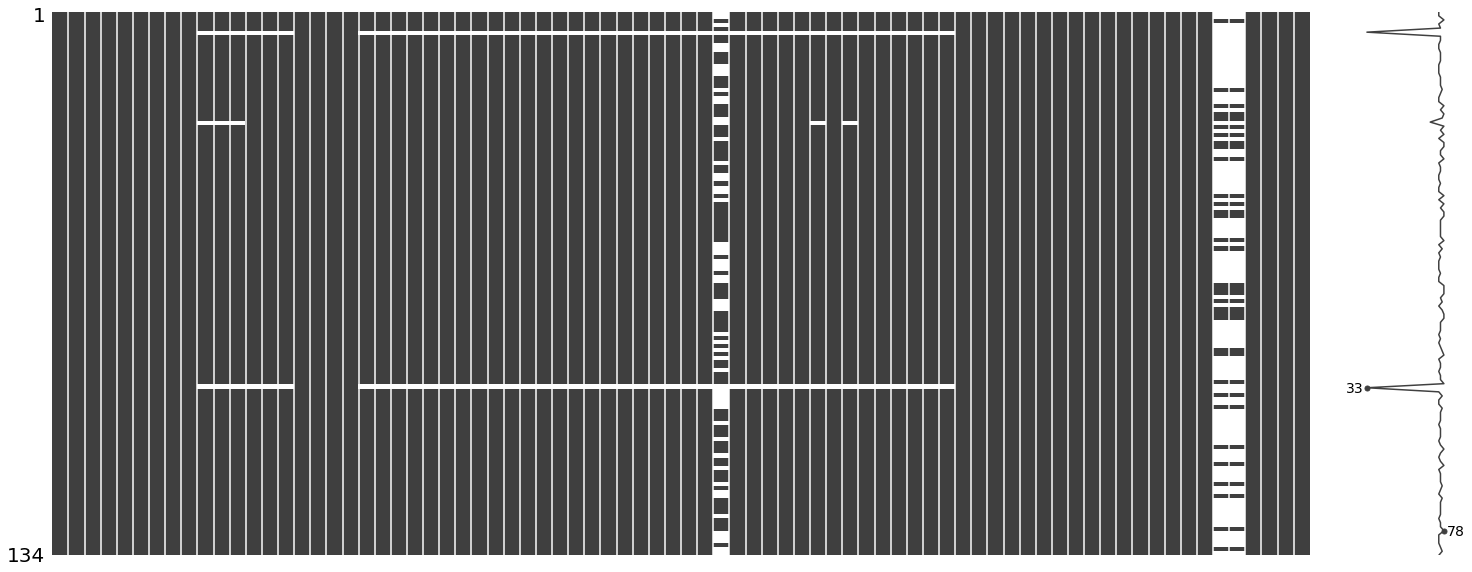

In [40]:
import missingno as msno
msno.matrix(ltc_mainland)

In [20]:
# Review 3 homes with missing values
ltc_mainland[ltc_mainland['DCH_NURSE_LASTYR'].isnull()]

,FACILITY_NAME,HCC_CODE,HLTH_AUTH,OWNERSHIP,STREET_ADDRESS,CITY,POSTAL,REGULATION,ACCRED_STATUS,DCH_NURSE_LASTYR,DCH_ALLIED_LASTYR,DCH_TOTAL_LASTYR,DCH_NURSE_CURRENTYR,DCH_ALLIED_CURRENTYR,DCH_TOTAL_CURRENTYR,BEDS_TOTAL,ROOMS_PRIVATE,ROOMS_SEMI,ROOMS_MULTI,COMPLAINTS,SUB_COMPLAINTS,INCIDENT_OUTBREAK,INCIDENT_ABUSE,INCIDENT_FALL,INCIDENT_POISON,INCIDENT_MEDICATION,INCIDENT_WANDERING,INCIDENT_INJURY,INCIDENT_AGGRESSION,INCIDENT_OUTBREAK_100,INCIDENT_ABUSE_100,INCIDENT_FALL_100,INCIDENT_POISON_100,INCIDENT_MEDICATION_100,INCIDENT_WANDERING_100,INCIDENT_INJURY_100,INCIDENT_AGGRESSION_100,AGE,FEMALE,AGE_85_PLUS,AGE_UNDER_65,STAY_LENGTH,DEPRESSION,ADL_DEPENDENT,CPS_SEVERE,DEMENTIA,ABS_PHYS_ABUSIVE,ISE,ISE_LOW,CMI,THERAPY_PT,THERAPY_RT,THERAPY_OT,MEDS_DEPRESSION,MEDS_ANTIPSYCHOTICS,RESTRAINTS,INSPECTIONS,INFRACTIONS,INFRACTIONS_LICENSING,INFRACTIONS_FACILITY,INFRACTIONS_STAFFING,INFRACTIONS_POLICY,INFRACTIONS_CARE,INFRACTIONS_DISEASE,INFRACTIONS_FOOD,INFRACTIONS_MEDICATION,INFRACTIONS_PROGRAM,INFRACTIONS_REPORTING,INFRACTIONS_RIGHTS,INFRACTIONS_OTHER,latitude,longitude,Total Confirmed Cases,Total Deaths,outbreak,RESIDENT_COUNCIL,FAMILY_COUNCIL,BEDS_PRIVATEprop
13,Bella Coola General Hospital,9A8DC,Vancouver Coastal Health,HA,1025 Elcho Street,Bella Coola,V0T1C0,Hospital Act,Accredited,NaN,NaN,NaN,NaN,NaN,NaN,5,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.374176,-126.757950,NaN,NaN,0,True,True,0.0000
59,Delta View Habilitation Centre,9C280,Fraser Health,PFP,9341 Burns Drive,Delta,V4K3N3,Hospital Act,Accredited,NaN,NaN,NaN,2.58,0.22,2.8,80,72,4,0,0,0,0,0,4,0,0,1,0,0,0.0,0.0,5.0,0.0,0.0,1.3,0.0,0.0,79.0,66.7,33.3,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.092204,-122.965047,NaN,NaN,0,True,True,0.1125
206,R. W. Large Memorial Hospital,9A773,Vancouver Coastal Health,HA,88 Waglisla Street,Bella Bella,V0T1Z0,Hospital Act,Accredited,NaN,NaN,NaN,NaN,NaN,NaN,7,7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,52.161211,-128.143320,NaN,NaN,0,False,False,0.0000


In [22]:
# Remove 3 homes with missing values
ls =['Bella Coola General Hospital', 
     'Delta View Habilitation Centre',
     'R. W. Large Memorial Hospital']

ltc_mainland = ltc_mainland[~ltc_mainland['FACILITY_NAME'].isin(ls)]




In [24]:
# Remove predictors with missing values from the remaining dataset (STAYLENGTH)
ltc_mainland = ltc_mainland.dropna(axis=1)
ltc_mainland.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 3 to 299
Data columns (total 75 columns):
FACILITY_NAME              131 non-null object
HCC_CODE                   131 non-null object
HLTH_AUTH                  131 non-null object
OWNERSHIP                  131 non-null object
STREET_ADDRESS             131 non-null object
CITY                       131 non-null object
POSTAL                     131 non-null object
REGULATION                 131 non-null object
ACCRED_STATUS              131 non-null object
DCH_NURSE_LASTYR           131 non-null float64
DCH_ALLIED_LASTYR          131 non-null float64
DCH_TOTAL_LASTYR           131 non-null float64
DCH_NURSE_CURRENTYR        131 non-null float64
DCH_ALLIED_CURRENTYR       131 non-null float64
DCH_TOTAL_CURRENTYR        131 non-null float64
BEDS_TOTAL                 131 non-null int64
ROOMS_PRIVATE              131 non-null int64
ROOMS_SEMI                 131 non-null int64
ROOMS_MULTI                131 non-null int64


In [25]:
# Export noNHorVIHA dataset
ltc_mainland.to_csv(r'../data/BC/ngan_bc_ltc_mainland.csv', index = False)

Aggregate preditors
- Sum incidents except of outbreak
- Sum infractions except of disease
- take a mean value for DCH

In [ ]:
ltc_fil2['INCIDENTS'] = ltc_fil2[[    
    'INCIDENT_ABUSE_100', 
    'INCIDENT_FALL_100', 
    'INCIDENT_POISON_100',
    'INCIDENT_MEDICATION_100', 
    'INCIDENT_WANDERING_100',
    'INCIDENT_INJURY_100', 
    'INCIDENT_AGGRESSION_100']].sum(axis=1)

ltc_fil2['INFRACTIONSall'] = ltc_fil2['INFRACTIONS'] - ltc_fil2['INFRACTIONS_DISEASE']

ltc_fil2['DCHnurse'] = (ltc_fil2['DCH_NURSE_LASTYR']+ltc_fil2['DCH_NURSE_CURRENTYR'])/2
ltc_fil2['DCHallied'] = (ltc_fil2['DCH_ALLIED_LASTYR']+ltc_fil2['DCH_ALLIED_CURRENTYR'])/2
ltc_fil2['DCHtotal'] = (ltc_fil2['DCH_TOTAL_LASTYR']+ltc_fil2['DCH_TOTAL_CURRENTYR'])/2


ls = [
    'DCH_NURSE_LASTYR',
    'DCH_ALLIED_LASTYR', 
    'DCH_TOTAL_LASTYR', 
    'DCH_NURSE_CURRENTYR',
    'DCH_ALLIED_CURRENTYR', 
    'DCH_TOTAL_CURRENTYR', 
    'INFRACTIONS',
    'INFRACTIONS_LICENSING', 
    'INFRACTIONS_FACILITY',
    'INFRACTIONS_STAFFING', 
    'INFRACTIONS_POLICY', 
    'INFRACTIONS_CARE',
    'INFRACTIONS_FOOD',
    'INFRACTIONS_MEDICATION', 
    'INFRACTIONS_PROGRAM',
    'INFRACTIONS_REPORTING', 
    'INFRACTIONS_RIGHTS', 
    'INFRACTIONS_OTHER',
    'INCIDENT_ABUSE_100', 
    'INCIDENT_FALL_100', 
    'INCIDENT_POISON_100',
    'INCIDENT_MEDICATION_100', 
    'INCIDENT_WANDERING_100',
    'INCIDENT_INJURY_100', 
    'INCIDENT_AGGRESSION_100',
    'INCIDENT_OUTBREAK',
    'INCIDENT_ABUSE', 
    'INCIDENT_FALL', 
    'INCIDENT_POISON',
    'INCIDENT_MEDICATION', 
    'INCIDENT_WANDERING', 
    'INCIDENT_INJURY',
    'INCIDENT_AGGRESSION'
]
ltc_fil2.drop(ls, axis = 1, inplace = True)

In [ ]:
ltc_fil2.info()

# Variable Selection Process
- Datasets
    - ltc_fil2, 5 homes removed, 289
    - ltc_noNH, 267
    - ltc_noVIHA, 231
    - ltc_noNHorVIHA, 209
    

In [ ]:
# Proportion of values missing for each column
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))
missing(ltc_fil2)

In [ ]:
missing(ltc_noNH)

In [ ]:
missing(ltc_noVIHA)

In [ ]:
missing(ltc_noNHorVIHA)

In [ ]:
# Review homes for which values are missing
ltc_noNHorVIHA[ltc_noNHorVIHA['CMI'].isnull()]

# ltc['CMI'].value_counts()


In [ ]:
import missingno as msno
msno.matrix(ltc_noNHorVIHA)

In [ ]:
# Remove Delta View Habilitation Centre which has all the missing values
ltc_noNHorVIHA = ltc_noNHorVIHA.loc[ltc_noNHorVIHA['FACILITY_NAME'] != 'Delta View Habilitation Centre'] 

# Remove Stay length as this has many missing values, and other preditors
ls = [
        
    'ISE',
    'STAY_LENGTH','INCIDENT_OUTBREAK',
    'INCIDENT_ABUSE', 'INCIDENT_FALL', 'INCIDENT_POISON',
    'INCIDENT_MEDICATION', 'INCIDENT_WANDERING', 'INCIDENT_INJURY',
    'INCIDENT_AGGRESSION', 
    'INFRACTIONS_LICENSING', 'INFRACTIONS_FACILITY',
    'INFRACTIONS_STAFFING', 'INFRACTIONS_POLICY', 'INFRACTIONS_CARE',
    'INFRACTIONS_FOOD',
    'INFRACTIONS_MEDICATION', 'INFRACTIONS_PROGRAM',
    'INFRACTIONS_REPORTING', 'INFRACTIONS_RIGHTS', 'INFRACTIONS_OTHER',
]
ltc_noNHorVIHA.drop(ls, axis = 1, inplace = True)
ltc_noNHorVIHA.info()

In [ ]:
# Export noNHorVIHA dataset
ltc_noNHorVIHA.to_csv(r'../data/BC/bc_ltc_noNHorVIHA.csv', index = False)

In [ ]:
# Drop columns
# Columns commented are being kept

listofcols = [
#     'HCC_CODE', 
#     'FACILITY_NAME', 
#     'HLTH_AUTH', 
#     'OWNERSHIP',

    'OPEN_DATE', # Unclear what this means, one entry 2009/2016
#     'COUNCIL', # Can keep to derive variables family/resident council
#     'REGULATION', 
#     'ACCRED_STATUS', 

    
    # DCH funded, not delivered (respresents a calculation from the HA)
    'DCH_NURSE_LASTYR',
    'DCH_ALLIED_LASTYR', 
    'DCH_TOTAL_LASTYR', 
    'DCH_NURSE_CURRENTYR',
    'DCH_ALLIED_CURRENTYR', 
    'DCH_TOTAL_CURRENTYR', 
    
#     'BEDS_PRIVATE',
#     'BEDS_PUBLIC', 
#     'BEDS_TOTAL', 
    
    # Given the 5 homes 0s for all ROOMS variables, will remove
#     'ROOMS_PRIVATE', 
#     'ROOMS_SEMI',
#     'ROOMS_MULTI', 
    
    # Do we need complaints and incidents data from previous years?
    
    # Note that Northern Health does not report complaints for facilities licensed under the Hospital Act
    # There are 11 homes without complaints/sub-complaints data, 10 of these are in NH (Hospital Act)
    # There are 4 homes with suppressed complaints/sub-complaints data 
    # Consider categorizing complaints as 0, >0, unknown
    
    # There are 139 homes with 0 complaints
#     'COMPLAINTS', 
    
    # There are 201 homes with 0 sub-complaints
#     'SUB_COMPLAINTS', 

    # Note that Island Health does not report on incidents at their Hospital Act facilities

    # Incident numbers not as useful as rates below
    'INCIDENT_OUTBREAK',
    'INCIDENT_ABUSE', 
    'INCIDENT_FALL', 
    'INCIDENT_POISON',
    'INCIDENT_MEDICATION', 
    'INCIDENT_WANDERING', 
    'INCIDENT_INJURY',
    'INCIDENT_AGGRESSION', 
    
    # One years worth of incidents does not seem useful
    # Can we get incident rates from previous years and take a mean?
    
    # Is this data too granular? Should incidents be summed? 
    # Or should we only keep incident of outbreaks? 149 homes had a 0 value, should bin them 0, >0, unknown?
    # 4 are suppressed
    
    'INCIDENT_OUTBREAK_100',
    'INCIDENT_ABUSE_100', 
    'INCIDENT_FALL_100', 
    'INCIDENT_POISON_100',
    'INCIDENT_MEDICATION_100', 
    'INCIDENT_WANDERING_100',
    'INCIDENT_INJURY_100', 
    'INCIDENT_AGGRESSION_100', 
    
    'ADVERSE_EVENT', # 275 listed as not applicable 
    
    # Resident descriptors
    # Not relevant to outbreak status
    # May be relevant in terms of deaths
#     'AGE', 
#     'FEMALE', 
#     'AGE_85_PLUS', 
#     'AGE_UNDER_65',    
#     'STAY_LENGTH',
#     'DEPRESSION', 
#     'ADL_DEPENDENT', 
#     'CPS_SEVERE', 
#     'DEMENTIA',
#     'ABS_PHYS_ABUSIVE', 
    'ISE', # collinear
#     'ISE_LOW', 
    
    # CMI is a standardized method that reflects clinical complexity
    # CMI is high in HA homes
    # 4 homes are missing this
#     'CMI',
    
    # Care services measures, measure of quality? 
#     'THERAPY_PT',
#     'THERAPY_RT', 
#     'THERAPY_OT', 
    
    # Quality measures
#     'MEDS_DEPRESSION',
#     'MEDS_ANTIPSYCHOTICS', 
#     'RESTRAINTS', 
    
    # Unsure what this means
    'CONTRACTED_NURSING', 
    'CONTRACTED_CARE_AIDES',
    'CONTRACTED_HOUSEKEEPING', 
    'CONTRACTED_PLANT', 
    
    #  Per diem rates are not reported by health authority owned facilities 
    'PER_DIEM_LASTYR',
    'PER_DIEM_CURRENTYR', 
    
    # Only one years worth of inspections/infractions data which was just added in 2019 so past data not available
    # sum Infractions/inspections
    'INSPECTIONS', 
    'INFRACTIONS',
    'INFRACTIONS_LICENSING', 
    'INFRACTIONS_FACILITY',
    'INFRACTIONS_STAFFING', 
    'INFRACTIONS_POLICY', 
    'INFRACTIONS_CARE',
    'INFRACTIONS_DISEASE', ### binary
    'INFRACTIONS_FOOD',
    'INFRACTIONS_MEDICATION', 
    'INFRACTIONS_PROGRAM',
    'INFRACTIONS_REPORTING', 
    'INFRACTIONS_RIGHTS', 
    'INFRACTIONS_OTHER',
    
    # Outcome variables
#     'num_cases', 
#     'num_deaths',
#     'outbreak'
]



ltc_noNH2 = ltc_noNH.drop(listofcols, axis = 1)
ltc_noNH2.info()

In [ ]:
# 5 homes have 0s for all the ROOMS categories
# Question of how reliable this data is
ltc_fil2.loc[ltc_fil2['ROOMS_PRIVATE'] == 0]

In [ ]:
# ltc.columns.values

# # Show rows with NA values
# ls = [
#     'ROOMS_PRIVATE', 
#     'ROOMS_SEMI',
#     'ROOMS_MULTI'
# ]

# for each in ls:
#     ltc[ltc[each].isnull()]

# ltc['INCIDENT_OUTBREAK_100'].describe()
ltc['CMI'].value_counts()
ltc[ltc['INFRACTIONS_DISEASE'].isnull()]
# len(ltc[ltc['INCIDENT_OUTBREAK_100'].isnull()])
# ltc['INFRACTIONS'].sum()




In [ ]:
ltc2.info()

In [ ]:
# Define new variables for resident and family councils
ltc2['RESIDENT_COUNCIL'] = ltc2['COUNCIL'].str.contains('Resident', regex=False, na=False)
ltc2['FAMILY_COUNCIL'] = ltc2['COUNCIL'].str.contains('Family', regex=False, na=False)

# Drop council var
ltc2 = ltc2.drop('COUNCIL', axis = 1)
# ltc2.head()

In [ ]:
# Define proportion of private vs public beds
ltc2['BEDS_PRIVATEprop'] = ltc2['BEDS_PRIVATE']/ltc2['BEDS_TOTAL']
ltc2['BEDS_PUBLICprop'] = ltc2['BEDS_PUBLIC']/ltc2['BEDS_TOTAL']

# Drop orig count var
ltc2 = ltc2.drop(['BEDS_PRIVATE', 'BEDS_PUBLIC'], axis = 1)

In [ ]:
# Complaints data
# Define a new categorical variable for complaints
# ltc2[ltc2['COMPLAINTS'] == '0'] 

conditions = [
    ltc2['COMPLAINTS'] == '0',
    ltc2['COMPLAINTS'] == 'suppressed',
    ltc2['COMPLAINTS'].isna()
]

outputs = [
    'zero', 
    'unknown', 
    'unknown'
]

res = np.select(conditions, outputs, 'greater than zero')
ltc2['COMPLAINTScat'] = pd.Series(res)

# Drop COMPLAINTS var
# ltc2 = ltc2.drop('COMPLAINTS', axis = 1)

In [ ]:
# Incidents data
# Review INCIDENT_OUTBREAK_100 var
ltc2['INCIDENT_OUTBREAK_100'].value_counts()
# Define a new categorical variable for INCIDENT_OUTBREAK_100

conditions = [
    ltc2['INCIDENT_OUTBREAK_100'] == '0.0',
    ltc2['INCIDENT_OUTBREAK_100'] == 'suppressed',
    ltc2['INCIDENT_OUTBREAK_100'].isna()
]

outputs = [
    'zero', 'unknown', 'unknown'
]

res = np.select(conditions, outputs, 'greater than zero')
ltc2['INCIDENT_OUTBREAK_100cat'] = pd.Series(res)

# # Drop INCIDENT_OUTBREAK_100cat var
# ltc2 = ltc2.drop('INCIDENT_OUTBREAK_100cat', axis = 1)


In [ ]:
# ltc2.info()
ltc2[ltc2.INCIDENT_OUTBREAK_100cat.isnull()]

In [ ]:
# Create a new variable which is the sum of the other INCIDENT var
ltc['INCIDENT_OUTBREAK_100'].value_counts()

In [ ]:
# Convert datatype for CMI
ltc2['CMI'] = pd.to_numeric(ltc2['CMI'])

In [ ]:
# # Convert datatype for OPEN_DATE
# ltc2['OPEN_DATE'].replace({'2009 / 2016': "2009"}, inplace=True)
# ltc2['OPEN_DATE'] = pd.to_numeric(ltc2['OPEN_DATE'])

# # Create new columns WRT facility dates (surrogate for design standards)
# ltc2.loc[ltc2['OPEN_DATE'] > 1994, 'facility_design'] = 'post1994'
# ltc2.loc[ltc2['OPEN_DATE'] < 1994, 'facility_design'] = 'pre1994'

In [ ]:
# Define total rooms and proportion of private rooms etc.
ltc2['ROOMS_TOTAL'] = ltc2['ROOMS_PRIVATE'] + ltc2['ROOMS_SEMI'] + ltc2['ROOMS_MULTI']
ltc2['ROOMS_PRIVATEprop'] = ltc2['ROOMS_PRIVATE']/ltc2['ROOMS_TOTAL']
ltc2['ROOMS_SEMIprop'] = ltc2['ROOMS_SEMI']/ltc2['ROOMS_TOTAL']
ltc2['ROOMS_MULTIprop'] = ltc2['ROOMS_MULTI']/ltc2['ROOMS_TOTAL']


In [ ]:
ltc2.info()
ltc2.head()
ltc2.columns.values

In [ ]:
listofcols = ['HLTH_AUTH', 'OPEN_DATE', 'COUNCIL']
ltc3 = ltc2.drop(listofcols, axis = 1)

In [ ]:
# For homes without facility design data, impute unknown
ltc3["facility_design"].fillna("unknown", inplace = True)
ltc3["facility_name"].fillna("na", inplace = True)
ltc3["num_cases"].fillna("na", inplace = True)
ltc3["num_deaths"].fillna("na", inplace = True)

In [ ]:
ltc3.info()

In [ ]:
# ltc3.loc[ltc3['DCH_NURSE_LASTYR'].isnull()]
ltc4 = ltc3[~ltc3.isna().any(axis=1)]
ltc4.info()

In [ ]:
ltc4.to_csv(r'../data/BC/ngan_bcLTC_foranalysis.csv', index = False)

In [ ]:
ltc2['facility_design'].value_counts()

# x = [i for i in ltc['OPEN_DATE'] if i>1994]
# len(x)

In [ ]:
ltc['ADVERSE_EVENT'].value_counts()
# Need to create new columns for Resident Council, Family Council 
